In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Wed May 24 15:52:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   27C    P8    13W / 230W |  16570MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [10]:
n_mels = 8
n_outputs = 61
n_frames = 400
sr = 24000
fps = 30
train_csv_files = ['/Storage/speech/face/MySlate_5_박수철의_iPhone_30fps.csv']
train_wav_files = ['/Storage/speech/face/MySlate_5_박수철의_iPhone.wav']

test_csv_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone_30fps.csv']
test_wav_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone.wav']

### Model

In [11]:
from model.model_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, out_dim=n_outputs)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [12]:
save_dir = '/data/scpark/save/lips/train05.19-6/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 7013, model, None, optimizer)

total 0


In [13]:
import torch
from data.dataset import LipsDataset, Collate

dataset = LipsDataset(train_wav_files, train_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=True)
print('train dataset :', len(dataset))
train_loader = torch.utils.data.DataLoader(dataset, num_workers=1, shuffle=True, batch_size=8, 
                                           collate_fn=Collate(n_frames, n_mels))
print(train_loader)

dataset = LipsDataset(test_wav_files, test_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=False)
print('test dataset :', len(dataset))
test_loader = torch.utils.data.DataLoader(dataset, num_workers=1, shuffle=True, batch_size=8,
                                           collate_fn=Collate(n_frames, n_mels))
print(test_loader)

train dataset : 8816
test dataset : 1413


test : 0 0.0380675233900547
test : 1 0.0396295040845871
test : 2 0.04033465310931206
test : 3 0.038875825703144073
test : 4 0.042276885360479355
test : 5 0.039836425334215164
test : 6 0.04163505509495735
test : 7 0.03985971584916115
test : 8 0.04040449112653732
test : 9 0.04292250797152519
test_loss : 0.040384259074926376


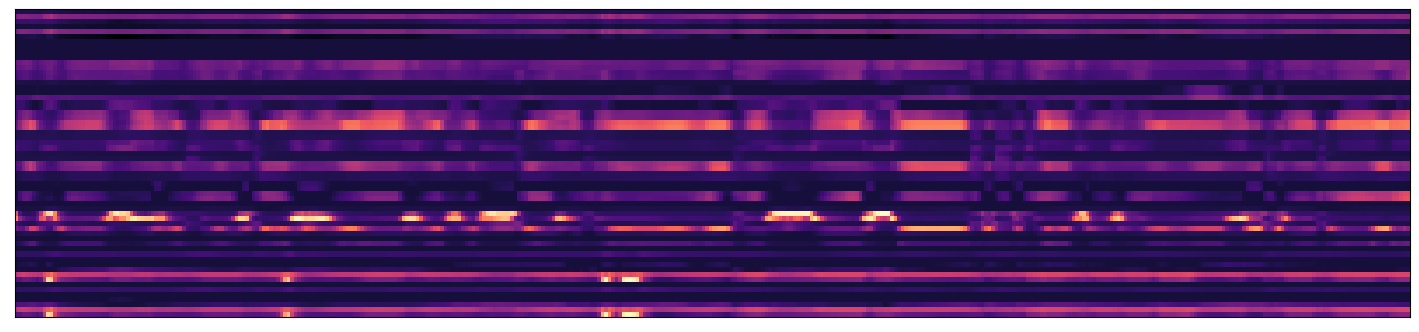

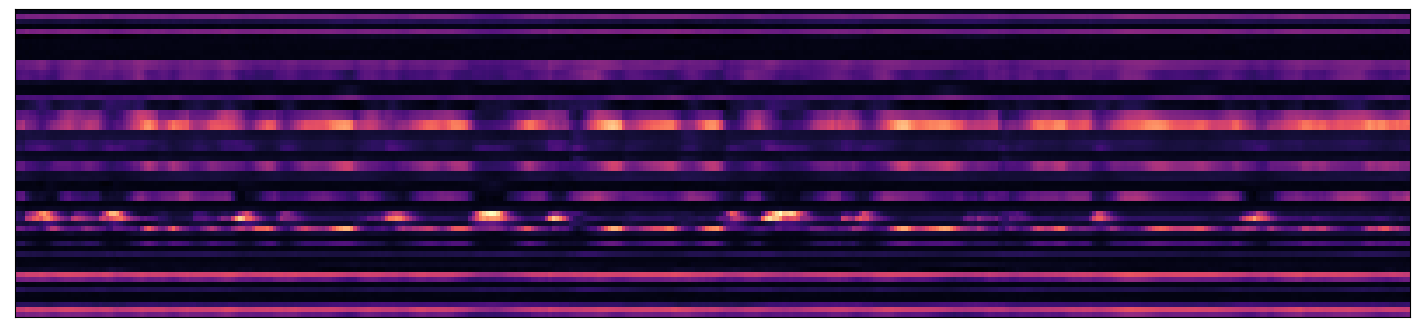

2501
loss 0.02012147568166256
2501 0.02012147568166256
2502
loss 0.020474335178732872
2502 0.020474335178732872
2503
loss 0.022679025307297707
2503 0.022679025307297707
2504
loss 0.019620483741164207
2504 0.019620483741164207
2505
loss 0.021474527195096016
2505 0.021474527195096016
2506
loss 0.022737419232726097
2506 0.022737419232726097
2507
loss 0.022012894973158836
2507 0.022012894973158836
2508
loss 0.019647493958473206
2508 0.019647493958473206
2509
loss 0.020751750096678734
2509 0.020751750096678734
2510
loss 0.02531832829117775
2510 0.02531832829117775
2511
loss 0.022543830797076225
2511 0.022543830797076225
2512
loss 0.020829947665333748
2512 0.020829947665333748
2513
loss 0.0204231645911932
2513 0.0204231645911932
2514
loss 0.02130703255534172
2514 0.02130703255534172
2515
loss 0.02103910781443119
2515 0.02103910781443119
2516
loss 0.02040059119462967
2516 0.02040059119462967
2517
loss 0.022686932235956192
2517 0.022686932235956192
2518
loss 0.019922662526369095
2518 0.0199226

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = batch['inputs'].transpose(1, 2).to(device)
        targets = batch['outputs'].transpose(1, 2).to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = batch['inputs'].transpose(1, 2).to(device)
                targets = batch['outputs'].transpose(1, 2).to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(outputs['y_pred'][0].data.cpu().numpy(), cmap='magma')
            plt.show()

        if step % 1000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)